# Topic modelling
A recurring subject in NLP is to understand large corpus of texts through topics extraction.
We used topic modeling to find the main topics in the articles. For the purposes of topic modeling, we used LDA (Latent Dirichlet Allocation Blei, Ng and Jordan, 2003) on the bag-of-words representation of articles. There are two main assumptions of LDA that make it a great tool for topic modeling in the sense of interpretability:
1. Documents with similar topics use similar groups of words
2. Topics of documents, which are called latent topics, can be found by searching for groups of words that frequently occur together in documents across the corpus.

And we can actually think of these two assumptions mathematically: we can say that documents are probability distributions over some underlying latent topics, and then topics themselves are probability distributions over words. So LDA represents documents as mixtures of topics that spit out words with certain probabilities.

## Methodology
1. Text preprocessing steps were applied:
- Lower casing
- Tokenization
- Removal of stopwords from a custom list of stopwords (smart stop list)
- Removal of punctuations
- Removal of numbers
- Lemmatization

2. Word Clouds for visualization
3. LDA for topic modeling

While most of the use of LDA is for unsupervised tasks, e.g. topic modelling or document clustering, it can also be used as a feature extraction system for supervised tasks such as text classification. 



In [2]:
import pandas as pd
df = pd.read_csv("./top7_preprocessed.csv", index_col=0)
df

,issue,text
0,"National Security, Defence, Foreign Affairs",washington today congressman brad sherman ca s...
2,"National Security, Defence, Foreign Affairs",house senate negotiator reached agreement mond...
3,"National Security, Defence, Foreign Affairs",washington today congressman brad sherman ca s...
4,"National Security, Defence, Foreign Affairs",washington september congressman brad sherman ...
5,"National Security, Defence, Foreign Affairs",cassandra sebastian washington congressman dou...
...,...,...
25638,Government and Law,invasion illegal alien southern border dominat...
25639,"National Security, Defence, Foreign Affairs",chicago il congressman jes chuy garc il issued...
25641,Energy and Environment,sherman oak ca seventh anniversary aliso canyo...
25642,Government and Law,rural san bernardino county targeted placement...


In [3]:
df.groupby("issue")["text"].count()

issue
Education                                      1411
Energy and Environment                         2380
Government and Law                             1015
Health Care and Social Security                2930
Jobs and the Economy                           2333
National Security, Defence, Foreign Affairs    3673
Veterans and Military                          1376
Name: text, dtype: int64

It is one of the most popular topic modeling methods. Each document is made up of various words, and each topic also has various words belonging to it. The aim of LDA is to find topics a document belongs to, based on the words in it.

Good resource: https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2


LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

### Parameters of LDA
- Alpha parameter is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.

- Beta parameter is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.



In [4]:
from sklearn.utils import resample
import numpy as np
df_filtered = pd.concat([
    resample(df[df['issue'] == label], 
             replace=False,
             n_samples=1015, 
             random_state=42)
    for label in df['issue'].unique()
])
df_filtered.groupby("issue")["text"].count()

issue
Education                                      1015
Energy and Environment                         1015
Government and Law                             1015
Health Care and Social Security                1015
Jobs and the Economy                           1015
National Security, Defence, Foreign Affairs    1015
Veterans and Military                          1015
Name: text, dtype: int64

In [5]:
most_common_words = set([
    'state', 'act', 'community', 'bill', 'federal', 'year', 'american', 'rep', 'house', 'congressman', 'program', 'today', 'service', 'support', 'member', 'committee'
])

In [6]:
from typing import List
def remove_most_common_words(words: List[str]):
    return [word for word in words if word not in most_common_words]

In [16]:
import gensim.corpora as corpora

data_words = [remove_most_common_words(doc.split()) for doc in df["text"].to_list()]
id2word = corpora.Dictionary(data_words)
id2word.filter_extremes(no_below=200, no_above=0.5)
corpus = [id2word.doc2bow(text) for text in data_words]

In [19]:
import gensim
import pyLDAvis.gensim_models
num_topics = 6
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
																																							iterations=200,
                                       passes=10,
                                       random_state=42)
lda_model.print_topics()
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(lda_display, f"LDA_results_2_attempt.html")
pyLDAvis.display(lda_display)

In [20]:
perplexity = lda_model.log_perplexity(corpus)
print('Perplexity: ', perplexity)

Perplexity:  -6.903632026451643


In [21]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
def compute_coherence_UMass(model, corpus, dictionary):
   coherence = CoherenceModel(model=model,
                              corpus=corpus,
                              dictionary=dictionary,
                              coherence='u_mass')
   return coherence.get_coherence()

num_topics=[3,4,5,6,7,8,9,10]
scores = []
for nr_topics in num_topics:
	lda_model = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=nr_topics, 
															random_state=42,
															passes=1, 
															iterations=10)
	score = compute_coherence_UMass(lda_model, corpus, id2word)
	print(score)
	scores.append(score)

-1.3724225524903197
-1.5169699438992426
-1.4868897647567105
-1.5364579507468796
-1.5275168752206305
-1.63012455701555
-1.537478245769396
-1.5245815819515036


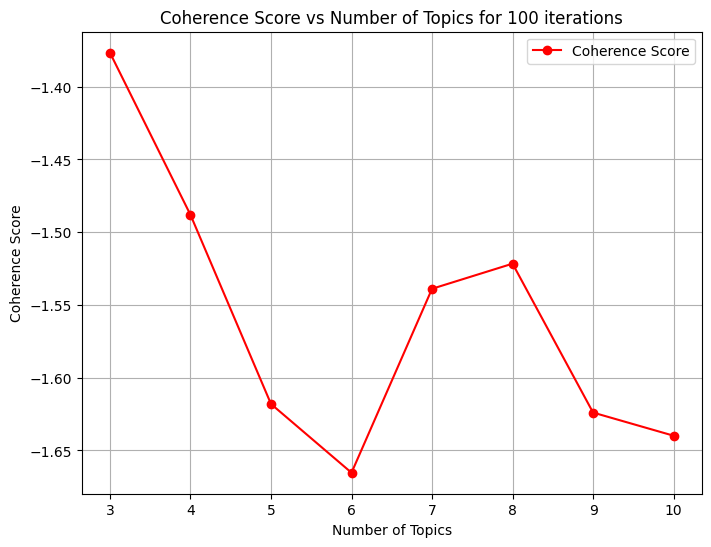

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(num_topics, scores, marker='o', linestyle='-', color='r', label='Coherence Score')

# Add labels and title
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics for 100 iterations')
plt.legend()

# Show the plot
plt.grid()
plt.show()

According to the UMASS coherence measurements, the coherence of the topics globally decreases when K increases." K is the number of topics. 

---

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', 
                            min_df=100, max_df=0.5,
																												ngram_range = (1,4))
doc_mx = tfidf_vec.fit_transform(df["text"])

In [52]:
from sklearn.decomposition import LatentDirichletAllocation
num_topics=7
model = LatentDirichletAllocation(n_components=num_topics,
                                            random_state=42)
lda_matrix = model.fit_transform(doc_mx)

In [53]:
# Print the topics with their terms
terms = tfidf_vec.get_feature_names_out()

for index, component in enumerate(model.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['water', 'project', 'funding', 'infrastructure', 'lamalfa', 'community', 'grant']
Topic 1:  ['health', 'care', 'health care', 'act', 'business', 'program', 'patient']
Topic 2:  ['president', 'iran', 'israel', 'khanna', 'war', 'norcross', 'trump']
Topic 3:  ['veteran', 'amata', 'va', 'military', 'defense', 'service', 'force']
Topic 4:  ['thompson', 'energy', 'climate', 'land', 'forest', 'gas', 'oil']
Topic 5:  ['mccollum', 'trump', 'krishnamoorthi', 'delauro', 'raja', 'raja krishnamoorthi', 'congressman raja']
Topic 6:  ['student', 'school', 'border', 'state', 'rep', 'congressman', 'education']
